## Topic model & Sentiment analysis on fine food reviews from Amazon

This project utilized the fine food product reviews data from Amazon, available from Kaggle: (https://www.kaggle.com/snap/amazon-fine-food-reviews/home)

The downloaded version contains 568,454 reviews from 1999 October to 2012 October on the web, contributed by more than 256,000 users on over 74,000 products. From the initial exploration on the dataset, it was noticed that most of the reviews were written during the last 3 years (2009 October to 2012 October), accounting for around 81% (462,423) of the total observations in the dataset. This might be driven by the widespreading popularity of Amazon online shopping platform after the mid-2000s. Among the users, 260 contributed more than 50 reviews.

In the dataset, the same review might be repeatedly recorded as the commenters might have consumed several products at one time or a set of products would be offered in one transaction, while sometimes it might be even caused by systematic errors or typing error. To prepare a standardized dataset of readiness for data mining, some steps of cleaning and checking were done to ensure one unit of observation was corresponding to one review.
 
After cleaning, for more efficient and target-oriented applications of machine learning techniques, I filtered the reviews from the last 3 years for conducting topic and sentiment analysis, and further focused on the relatively active users making at least 15 reviews (averagely 5 reviews per year) for constructing a recommendation system based on the similarity of their user behaviours and purchase history. There were two more features from the dataset that conveyed additional information: helpfulness of the reviews (as the proportion of the number of helpful votes over the total number of votes received); and rating score towards the consumed products.

### 1) Cleaning and Tokenization:

Preparing two sets of dataframe, one aggregating by product IDs and the raw text contents, and one aggregating by product IDs and tokenized lists of words, it could be shown 162 reviews were found to be redundant due to noises in the raw texts like spaces or special characters (567,527 vs 567,365). Compared to the original count (568,454), 1071 reviews were in fact duplicatedly captured. Making selection on the latest 3-year data, the reduced dataset consisted of 462,423 distinct combinations of product IDs tied with tokenized reviews.

The renowned Natural Language Toolkit (nltk) in Python was used for the pre-processing steps of tokenization and redundant special character and stop-word removal. Stemming or lemmatization has not been considered for interpretability issue, to avoid any implicit meaning caused by removing specific suffixes and prefixes and to retain the information of part of speeches, presuming we did not acquire any prior contextual knowledge about the word usage in these food reviews.

In [ ]:
import pandas as pd
import numpy as np
import seaborn
import matplotlib.pyplot as plt

## read dataset
reviews = pd.read_csv('Reviews.csv')
## covert timestamp to datetime
reviews['Time'] = pd.to_datetime(reviews['Time'], unit='s')

## normalizing by lowercasing, removing special characters, tokenizing, and removing stopwords
from nltk import word_tokenize
from nltk import corpus
import re
## define stopword list
stop_words = corpus.stopwords.words('english')
## cleaning noises in texts
def normalize_doc(doc):
    # lower-case
    doc = doc.lower()
    # substitute special characters, digits & punctuations
    doc = re.sub('<br/>', ' ', doc)
    doc = re.sub('<br />', ' ', doc)
    doc = re.sub("'s|'m|'re|'ve|'ll|'d|n't", ' ', doc)
    doc = re.sub(r'"', ' ', doc)
    doc = re.sub(r'[^a-zA-Z\s]\W+|\d+|[!?@#%^&*\[\]\\(){}<>]|[.]|[/]|[$]|[-;:,`~=_+]', ' ', doc)
    # remove leading and trailing spaces
    doc = doc.strip()
    # tokenize
    tokens = word_tokenize(doc)
    # discard stopwords
    filtered_tokens = [x for x in tokens if x not in stop_words]
    doc = ' '.join(filtered_tokens)
    return doc

## tokenization
text = reviews['Text']
summary = reviews['Summary']
token_list_text = []
token_list_text = [normalize_doc(x) for x in text]
token_list_summary = []
token_list_summary = [normalize_doc(str(x)) for x in summary]

In [4]:
## combine tokens from summary and review texts
token_list = []
token_list = [token_list_summary[x] + " " + token_list_text[x] for x in range(len(token_list_text))]

In [5]:
token_list[0:5]

['good quality dog food bought several vitality canned dog food products found good quality product looks like stew processed meat smells better labrador finicky appreciates product better',
 'advertised product arrived labeled jumbo salted peanuts peanuts actually small sized unsalted sure error vendor intended represent product jumbo',
 'delight says confection around centuries light pillowy citrus gelatin nuts case filberts cut tiny squares liberally coated powdered sugar tiny mouthful heaven chewy flavorful highly recommend yummy treat familiar story c lewis lion witch wardrobe treat seduces edmund selling brother sisters witch',
 'cough medicine looking secret ingredient robitussin believe found got addition root beer extract ordered good made cherry soda flavor medicinal',
 'great taffy great taffy great price wide assortment yummy taffy delivery quick taffy lover deal']

In [6]:
## read into dataframe
reviews['tokenized'] = pd.Series(token_list)

## duplicate checks on striped texts
dup1 = reviews.groupby(['Summary', 'Text', 'ProductId']).agg({'ProductId':['count']})
dup1 = dup1.reset_index(level=['Summary', 'Text', 'ProductId'])
dup1.columns = ['Summary', 'Text', 'ProductId', 'Count']

## duplicate checks on tokenized texts
dup2 = reviews.groupby(['tokenized', 'ProductId']).agg({'ProductId':['count']})
dup2 = dup2.reset_index(level=['tokenized', 'ProductId'])
dup2.columns = ['tokenized', 'ProductId', 'Count']

print("Aggegrating by Product ID + raw texts: " + str(len(dup1)))
print("Aggegrating by Product ID + tokenized texts: " + str(len(dup2)))

Aggegrating by Product ID + raw texts: 567527
Aggegrating by Product ID + tokenized texts: 567365


In [7]:
## Create dataframe per one document per product as one observation unit
reviews_reduced = reviews.groupby(['tokenized', 'ProductId', 'UserId']).agg(
                                  {'ProfileName': 'first',
                                   'HelpfulnessNumerator': ['max'],
                                   'HelpfulnessDenominator': ['max'],
                                   'Score': ['max'], 'Time': ['max'],
                                   'Summary': 'first', 'Text': 'first'})
reviews_reduced = reviews_reduced.reset_index(level=['tokenized', 'ProductId', 'UserId'])
reviews_reduced.columns = ['tokenized', 'ProductId', 'UserId', 'ProfileName', 'HelpfulVote', 
                           'AllVote', 'Score', 'Time', 'Summary', 'Text']
## extract last 3 years
reviews_reduced = reviews_reduced[reviews_reduced['Time']>=pd.Timestamp(2009,10,1)]

In [8]:
reviews_reduced.shape

(462423, 10)

In [11]:
## aggregations by unique review documents
unique_doc = reviews_reduced.groupby(['tokenized']).agg(
                                   {'ProfileName': 'first',
                                   'HelpfulVote': ['max'],
                                   'AllVote': ['max'],
                                   'Score': ['max'], 'Time': ['max'],
                                   'Summary': 'first', 'Text': 'first'})
unique_doc = unique_doc.reset_index(level=['tokenized'])
unique_doc.columns = ['tokenized', 'ProfileName', 'HelpfulVote', 'AllVote', 'Score', 'Time', 'Summary', 'Text']

In [12]:
unique_doc.shape

(321847, 8)

Word clouds could give preliminary impressions on product-specific descriptions or customer comments. It displayed the agglomerate of tokens with the sizes proportional to their frequency. Aggregated by the product ID, the following code enabled us to query the contents by building the word cloud of a specific product we were interested in. Simply type the product ID stored in the "product_to_query" variable, and the distributions of all tokens regarding to this product could be mapped.

In [35]:
## Displaying word cloud for distribution of most weighted tokens for each product
from wordcloud import WordCloud, ImageColorGenerator
import imageio
import os

# read a masked image for the style of the word cloud
mask = np.array(imageio.imread(os.path.join('./', 'food.jpeg')))
mask_color = ImageColorGenerator(mask)

# create product-specific token lists
product_to_query = 'B001GVISJM'
product = reviews_reduced[reviews_reduced['ProductId']==product_to_query]

## extract all reviews of the quoted product
## transform the strings to arrays of tokens
product_token_array = []
for t in range(len(list(product['tokenized']))):
    word = list(product['tokenized'])[t].split(' ')
    product_token_array.append(word)
## create a strings
for_product_word_cloud = []
for l in range(len(product_token_array)):
    for_product_word_cloud.append(' '.join(str(x) for x in product_token_array[l]))

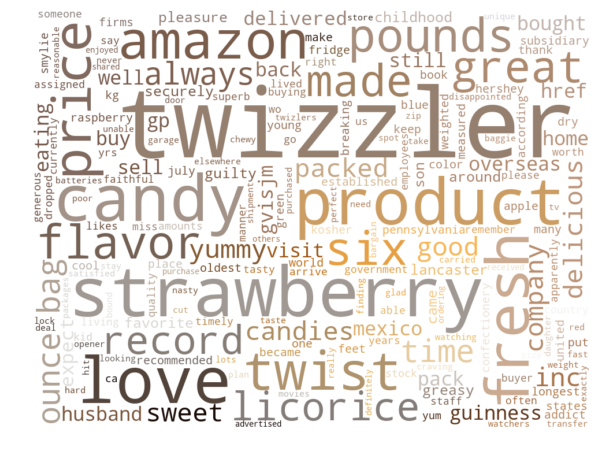

In [38]:
# build word cloud for the first product
wordcloud = WordCloud(background_color="white", mode="RGBA", mask=mask)
wordcloud = wordcloud.generate(str(' '.join(str(x) for x in for_product_word_cloud)))
plt.figure(figsize=[10,10])
plt.imshow(wordcloud.recolor(color_func=mask_color), interpolation="bilinear")
plt.axis("off")
plt.show()

### 2) Topic modelling:

Topic model could be a tool for identifying the latent semantic features by grouping similar tokens, and hence entailing a label given to the documents. 

Two types of topic extraction techniques were adopted to make a basic and subjective comparison on the thematic features inferred from these tokens. LDA (Latent Dirichlet Allocation) would be a probabilistic and iterative model with a prior probability distribution of tokens that are supposed to be generated from *K* topics, drawing topics for each document and drawing tokens from topics following the Dirichlet distribution. Iterating through each observed word in the document, the posterior probability could be computed from the conditional topic distributions and word distributions. The perplexity and log-likelihood would be the measures for validating the optimal number of topics to be chosen.

Meanwhile, NMF (non-negative matrix factorization) has been also prevalently used in the domain of topic formation, which decomposed the document-token matrix into a document-topic matrix (weights of topics in each document) and a topic-token matrix (weights of tokens allocating to each topic), and the weightings were computed with matrix multiplicative updates for the minimization of loss or divergence distance (expectation-maximization steps), while other optimization algorithms like coordinate descent updating the weights with addition of derivative terms. Again, the number of *K* topics (analogous to the number of components in dimensionality reduction) needs to be specified.

Document-term matrix was our prior step of getting inputs for LDA models. A bag of n-grams model weighted by TF-IDF scheme are usually the desirable format. TF-IDF formula scales down the influence of frequent words in the corpus co-occurring in a large number of documents (inverse-document frequency). The document-term matrix would be expectedly sparse with a lot of zeros. Number of features could be controlled by specifying the minimum and maximum frequency appeared in the corpus, an absolute count was normally used as minimum to eliminate rare words (token appeared at least 10 times) and a percentile would set the upper limit for the maximum allowance to include (tokens coherently occurred in 90% of documents). Mined from the 321,847 unique reviwes we got 22,488 word features from this range.

Memory and time concerns could be unfavorable for training a large corpus on local machine with hardware constraints. The enormous-sized matrix would be read in compressed row (CSR) matrix format as acquired through functions in scipy library. To further save the training time which might takes mulitple hours to days to complete, instead of inputting the document-token matrix for the model as usual, I manually applied matrix multiplications to find the dot product between the product-document matrix and the TF-IDF matrix to get the product-term matrix. For validating the number of topics, perplextity and log-likelihood were 2 determining metrics to look on. 

In [13]:
## uni-gram model weighted by TF-IDF
from sklearn.feature_extraction.text import TfidfVectorizer
## discard tokens appeared in fewer than 10 reviews and more than 90% of all reviews
tfidf = TfidfVectorizer(min_df=10, max_df=0.9, use_idf=True)
tfidf_matrix = tfidf.fit_transform(list(unique_doc['tokenized']))
tfidf_terms = tfidf.get_feature_names()

## create review-product one hot encoded matrix
from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder()
product_doc_matrix = ohe.fit_transform(reviews_reduced[['ProductId']])
product_feature_name = ohe.get_feature_names()
token_text_id_matrix = ohe.fit_transform(reviews_reduced[['tokenized']])
product_doc_matrix = np.dot(token_text_id_matrix.T, product_doc_matrix)

## dot product to get product-term matrix
product_term_matrix = np.dot(product_doc_matrix.T, tfidf_matrix)

In [14]:
tfidf_matrix.shape

(321847, 22488)

In [15]:
product_doc_matrix.shape

(321847, 68881)

In [16]:
product_term_matrix.shape

(68881, 22488)

In [17]:
## column order following feature names
product_feature_name[0:50]

array(['x0_141278509X', 'x0_2841233731', 'x0_6641040', 'x0_7310172001',
       'x0_7310172101', 'x0_7800648702', 'x0_9376674501', 'x0_B00002N8SM',
       'x0_B00002NCJC', 'x0_B00004CI84', 'x0_B00004CXX9', 'x0_B00004RAMS',
       'x0_B00004RAMV', 'x0_B00004RAMX', 'x0_B00004RAMY', 'x0_B00004RBDU',
       'x0_B00004RBDW', 'x0_B00004RBDZ', 'x0_B00004RYGX', 'x0_B00004S1C5',
       'x0_B00004S1C6', 'x0_B000052Y74', 'x0_B00005344V', 'x0_B0000535LF',
       'x0_B0000537KC', 'x0_B00005C2JE', 'x0_B00005C2M2', 'x0_B00005C2M3',
       'x0_B00005IX96', 'x0_B00005IX97', 'x0_B00005IX98', 'x0_B00005OMWO',
       'x0_B00005OMWQ', 'x0_B00005U2FA', 'x0_B00005V3DC', 'x0_B0000643LM',
       'x0_B00006FMLY', 'x0_B00006G930', 'x0_B00006IDK9', 'x0_B00006L2ZT',
       'x0_B00006LL38', 'x0_B00008433V', 'x0_B000084346', 'x0_B00008434E',
       'x0_B00008437P', 'x0_B000084388', 'x0_B000084DWM', 'x0_B000084DXS',
       'x0_B000084E66', 'x0_B000084E6V'], dtype=object)

In [18]:
product_name = [x.split("_")[1] for x in product_feature_name]

In [19]:
## Apply LDA for topic modelling
## obtain likelihood / perplexity score for validation of number of topics
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.utils import shuffle
from scipy import sparse

In [34]:
## shuffle the data
## train-test set split
shuffle_LDA = shuffle(product_term_matrix, random_state=0)
Train_LDA = shuffle_LDA.tocsc()[0:int(product_term_matrix.shape[0]*2/3),:]
Test_LDA = shuffle_LDA.tocsc()[-int(product_term_matrix.shape[0]*1/3):,:]
perplexity_Train = []
perplexity_Test = []
log_lik_train = []
log_lik_test = []
for n in range(2, 15):
    lda = LatentDirichletAllocation(n_components=n, max_iter=100, random_state=42)
    # instead of document-term matrix, use product-term matrix as input to save training time
    # investigate the perplexity and log-likelihood
    lda_topic_n = lda.fit(Train_LDA)
    perplexity_Train.append(lda_topic_n.perplexity(Train_LDA))
    perplexity_Test.append(lda_topic_n.perplexity(Test_LDA))
    log_lik_train.append(lda_topic_n.score(Train_LDA))
    log_lik_test.append(lda_topic_n.score(Test_LDA))

[Text(0,0.5,'log-likelihood')]

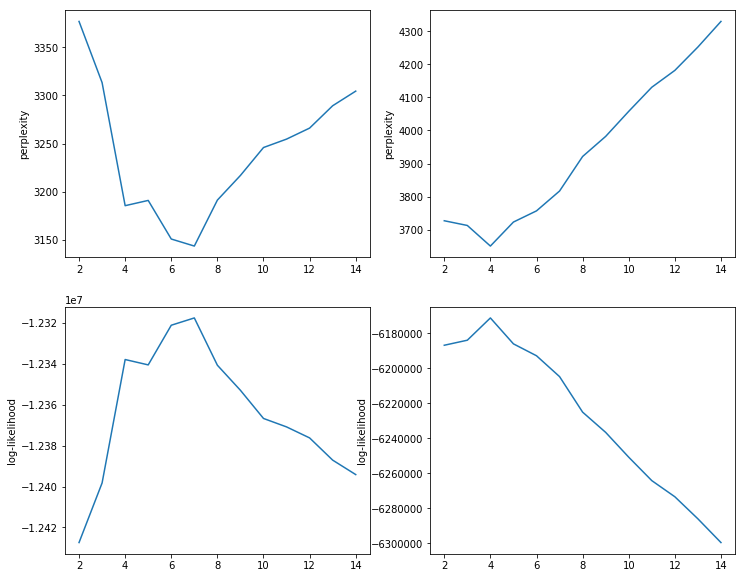

In [49]:
fig, ax = plt.subplots(2,2,figsize=(12,10))
seaborn.lineplot(x=range(2,15), y=perplexity_Train, ax=ax[0,0]).set(ylabel='perplexity')
seaborn.lineplot(x=range(2,15), y=perplexity_Test, ax=ax[0,1]).set(ylabel='perplexity')
seaborn.lineplot(x=range(2,15), y=log_lik_train, ax=ax[1,0]).set(ylabel='log-likelihood')
seaborn.lineplot(x=range(2,15), y=log_lik_test, ax=ax[1,1]).set(ylabel='log-likelihood')

From the above plots, the minimum of the perplexity (inverse probability of unseen data) and the maximum of log-likelihood of the training data occurred at 6 to 7 topics, while on test data, the extrema took place at 4 topics.

From the 7-topic LDA model, the highest-weighted 50 tokens might be concluded as:

Topic 1: Words associated with tastes & flavours of ingredients or food products;  
Topic 2: contents of teas, including different types (herbal, earl, lemon, etc.); 
Topic 3: contents of coffee, including brands (Starbucks, Keurig), types and flavours;  
Topic 4: contents of sweet fine food like chocolate, cookies, cake;  
Topic 5: generally about beverages (water, milk, soda, etc.) and nutritional concerns;  
Topic 6: fine foods purchased for dogs and cats;  
Topic 7: contents of crunchy snacks

In [21]:
# fit the LDA model with 7 topics
col1 = []
for i in range(1,8):
    col1.append('Topic' + str(i))
lda = LatentDirichletAllocation(n_components=7, max_iter=100, random_state=42)
lda_matrix = lda.fit_transform(product_term_matrix)
lda_topic = pd.DataFrame(lda_matrix, columns=col1)

In [53]:
# investigate the 7 topics fitted with the top-weighted 50 terms within the topic
for t, topics in enumerate(lda.components_):
    print('Topic %d: ' % (t+1))
    print('"' + '", "'.join([tfidf_terms[j]
                for j in topics.argsort()[:-51:-1]]) + '"')

Topic 1: 
"sauce", "great", "good", "salt", "product", "use", "like", "flavor", "jerky", "soup", "hot", "oil", "best", "pasta", "taste", "rice", "one", "love", "make", "chicken", "would", "buy", "amazon", "used", "find", "price", "really", "time", "stuff", "add", "much", "easy", "spicy", "little", "get", "cheese", "noodles", "well", "food", "beef", "better", "delicious", "seasoning", "also", "quality", "cook", "excellent", "cooking", "even", "store"
Topic 2: 
"tea", "green", "teas", "great", "good", "flavor", "drink", "taste", "chai", "like", "love", "honey", "ginger", "bags", "stash", "one", "cup", "iced", "best", "product", "really", "black", "drinking", "day", "strong", "earl", "find", "hot", "price", "time", "amazon", "grey", "tastes", "favorite", "would", "delicious", "get", "tried", "nice", "much", "also", "better", "herbal", "bag", "matcha", "well", "mint", "sleep", "lemon", "wonderful"
Topic 3: 
"coffee", "cup", "cups", "great", "good", "flavor", "like", "strong", "taste", "bol

In [ ]:
# topic model interactive visualization
import pyLDAvis
import pyLDAvis.sklearn
LDA_7_topics_vis = pyLDAvis.sklearn.prepare(lda, tfidf.fit_transform(list(unique_doc['tokenized'])), tfidf)
pyLDAvis.display(LDA_7_topics_vis)

In [26]:
pyLDAvis.save_html(LDA_7_topics_vis, 'lda_7_topics_fine food reviews.html')

In [ ]:
from IPython.display import IFrame
IFrame(src='lda_7_topics_fine food reviews.html', width=1250, height=850)

<img src="./pic/LDA_7_topics_vis.PNG" width="1250" height="850" />

To try a faster and less computational expensive algorithm, NMF might be more efficient though compromising the lower accuracy. Specifying the same 7-topic models using NMF, we can get the highest-weighted 50 tokens as concluded:

Topic 1: contents of coffee, including brands (Starbucks, Keurig), types and flavours;  
Topic 2: health and nutritional issues on fats, calories, proteins intakes, etc.;  
Topic 3: fine foods purchased for pets;  
Topic 4: contents of teas, with more relevant and directed words about the types and flavours (chamomile, peppermint, licorice, etc.);  
Topic 5: contents of popcorns and snacks for movies;  
Topic 6: contents of potato chips;  
Topic 7: generally about drinks but also focusing on the benefits on choosing the drinks;  

Comparing the LDA and NMF topics, both were producing similar results. The top-weighted tokens in LDA topics seemed to be more "general" for subjective and intuitive interpretations of the themes, yet the weightings (i.e. token importance rankings within topics) could be adjusted with the parameter, lambda, as shown in the above LDA model visualizations. NMF topic extraction has fewer parameters for tuning, and it could rank the topic-specific and might be less frequent tokens higher in the results, especially the brands, flavours and ingredients / types. Under the 7-topic models, LDA probably grouped popcorns and chips as one group for crunchy snacks, while NMF distinguished the two, but lost one explicit topic for sweet fine foods.

In [23]:
## Apply NMF for topic modelling with 7 topics
from sklearn.decomposition import NMF
nmf = NMF(n_components=7, max_iter=100, init='nndsvd', solver='mu', random_state=42)
nmf_7_matrix = nmf.fit_transform(product_term_matrix)
nmf_7_topics = pd.DataFrame(nmf_7_matrix, columns=col1)

In [59]:
for t, topics in enumerate(nmf.components_):
    print('Topic %d: ' % (t+1))
    print('"' + '", "'.join([tfidf_terms[j]
                for j in topics.argsort()[:-51:-1]]) + '"')

Topic 1: 
"coffee", "cup", "cups", "strong", "flavor", "good", "like", "great", "bold", "taste", "one", "keurig", "vanilla", "roast", "starbucks", "love", "flavored", "bitter", "blend", "pods", "would", "dark", "smooth", "coffees", "best", "drink", "favorite", "price", "weak", "morning", "brew", "really", "tried", "jet", "nice", "fuel", "pod", "mountain", "product", "buy", "amazon", "french", "medium", "cappuccino", "get", "rich", "wolfgang", "much", "try", "puck"
Topic 2: 
"bars", "great", "good", "like", "love", "snack", "taste", "bar", "cookies", "really", "one", "flavor", "chocolate", "product", "kind", "healthy", "delicious", "sweet", "cookie", "would", "eat", "food", "best", "soft", "free", "tasty", "peanut", "try", "buy", "much", "little", "get", "yummy", "butter", "protein", "calories", "better", "tried", "flavors", "go", "fat", "gluten", "also", "favorite", "amazon", "even", "eating", "sugar", "make", "oatmeal"
Topic 3: 
"dog", "dogs", "treats", "greenies", "food", "loves", "t

In [24]:
## map the topic membership columns to the dataset
lda_topic_vec = np.array(lda_topic).argmax(axis=1)
nmf_topic_vec = np.array(nmf_7_topics).argmax(axis=1)

### 3) Doc2Vec review embeddings:

Topic modelling could give an idea as from the entire perspective, given no prior information detected beforehand. The TF-IDF matrix could be extremely sparse and suffering from the problem of dimensionality in the later analysis. To get the latent features, Word2Vec is a shallow neural network model that projects the tokens onto a high dimensional vector space through the word embedding layer. Additionally, the token similarity could be investigated by providing a token or between a pair of tokens. While two types of word2vec model were introduced in the gensim word2vec algorithms: **continuous bag of words (CBOW)** and **skip-gram**. The fundamental difference of the two is that CBOW used the former and latter words as inputs (contexts) to predict the current word, while skip-gram would take the opposite way to infer the neighnouring words by the current word. The practice below had implemented the CBOW algorithm as by default.

It was suggested to use 100 to 1000 features for representation and differentiation of each word, while fewer features might be sufficient for a smaller corpus and shorter texts. The window parameter referred to the maximum range of neighbouring words included with respect to the current word as an input (skip-gram) or output (CBOW). For long texts, window can be set higher over 100, now it was assigned to be 10 considering the relatively short lengths of fine food reviews. Only tokens having more than 10 frequency counts were retained, aligning to the minimum degree of freedom (10) in the previous TF-IDF scheme transformation. The "***model.most_similar()"*** function could display the relevant tokens with highest **Cosine Similarities** (proportional to the dot product of two vectors) to the queried token.

<img src="https://skymind.ai/images/wiki/word2vec_diagrams.png" width="600" height="500"/> 

To get representations distinguishing each review (document) as an individual unit, we can choose to aggregate the vectors derived from the Word2Vec model, or directly train a Doc2Vec model using the gensim library. Doc2Vec basically builds on the Word2Vec concept, typically with an additional dimension to represent the tagged document label. Again, there are two algorithms: one produced word vectors derived from CBOW (Distributed Memory version of paragraph vector); one produced word vectors from skip-gram (Distributed Bag of Words). For the Doc2Vec trial, the former DM version was implemented by default to generate 300 dimensions from the word and paragraph structure simultaneously. In Doc2Vec, the effect of document label can be fixed by specifying ***train_lbls=False***, or on the opposite, setting ***train_words=False*** to train only on the tagged document IDs. Analogous to Word2Vec, the Doc2Vec model allowed querying the similarity of documents as well.

<p style="text-align:center"><b>Distributed Memory of paragraph vector</b></p>
<img src="./pic/PVDM.png" width="400" height="500" />
<p style="text-align:center"><b>Distributed Bag of Words</b></p>
<img src="./pic/DBOW.png" width="400" height="500" /> 

In [25]:
## Apply Word2Vec model for vector space representation of documents;
## with t-SNE for dimensionality reduction and scaling
## plotly for generating interactive visualization
from gensim.models import doc2vec
from sklearn.manifold import TSNE
from mpl_toolkits.mplot3d import Axes3D
import plotly.plotly as ply
import plotly.graph_objs as go
import plotly.offline as offline
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

In [42]:
# split the tokenized strings and create another list  to store all tokens in the unique reviews
token = []
for t in range(len(list(unique_doc['tokenized']))):
    word = list(unique_doc['tokenized'])[t].split(' ')
    token.append(word)

In [43]:
# Document similarity
## fit a Doc2Vec model
documents = [doc2vec.TaggedDocument(doc, [i]) for i, doc in enumerate(token)]
d2v = doc2vec.Doc2Vec(documents, vector_size=300, window=10, min_count=10, seed=1, workers=1)
d2v.train(documents, total_examples=len(documents), epochs=30)

In [44]:
## save the model
d2v.save("Trained_Doc2Vec")

In [26]:
## load saved model
d2v = doc2vec.Doc2Vec.load("Trained_Doc2Vec")

In [27]:
## extract doc2vec dimensions
doc_v = []
doc_label = []
for doc in range(len(d2v.docvecs)):
    doc_v.append(d2v.docvecs[doc])
    doc_label.append('Review' + str(doc+1))
doc_vector = pd.DataFrame(doc_v)
v = []
for u in range(1, 301):
    v.append('doc2vec' + str(u))
v = np.array(v)
doc_vector.columns = v

In [28]:
doc_vector.shape

(321847, 300)

### 4): Sentiment classifier from product ratings

Based on the customer score ratings given to the products consumed, sentiment polarities could be determined, and hence connecting this outcome to the tokenized texts to build a sentiment classifier on the triggered words or linguistical patterns being used to describe the outstanding and inferior points associated to the products. It might be an option to engineer the rating variable into 3 categories: transforming to a 'positive', 'neutral', 'negative' group-splitting from the 5-point grading system; here we might re-define 1 to 2 points were regarded to be negatively-rated, and 3 points meant neutral, and 4 to 5 points indicated a positive attitude.

Looking back to the reviews themselves, we could add more features to the dataset as potential predictors that might be important contributing to the performance of our classifier, for instance, the length of reviews, topic classified from the topic models, TF-IDF vectorizer, doc2vec embeddings.

From the preliminary plot of the 3-class encoded target, the majority of reviews had reacted positively to the products consumed. It was interesting that reviews receiving a large number of votes (more than 150) meanwhile having a high proportion of helpful claims from other consumers. Based on the evaluations of other web-users on the reviews posted, we could define the conversion rate (proportion of helpful vote per voting response to the review) by setting it as a division of the number of helpful votes over the number of total votes. Most people were rendering voluntary response in a sense of a vote for agreement, and sometimes tended to be affected by the number of helpful votes the review had already got, that resulted in many 1.0 conversion in the data.

In [29]:
# Sentiment Analysis
## engineering the feature targets on user-product rating and helpfulness rating features
## define proportion of helpful votes
unique_doc['conv_rate'] = unique_doc['HelpfulVote'] / unique_doc['AllVote']
## define 1-2 points as negative & 4-5 points as positive
unique_doc['polarity'] = unique_doc['Score'].apply(lambda x: 'negative' if x < 3 else ('positive' if x > 3 else 'neutral'))
unique_doc['polarity_ord'] = unique_doc['Score'].apply(lambda x: 0 if x < 3 else (2 if x > 3 else 1))
## length of tokenized texts
unique_doc['review_length'] = unique_doc['tokenized'].apply(lambda x: len(x))
## topics
product_ldatopic_matrix = ohe.fit_transform(lda_topic_vec.reshape(-1, 1))
product_nmftopic_matrix = ohe.fit_transform(nmf_topic_vec.reshape(-1, 1))
unique_doc_LDA_topics = pd.DataFrame(np.dot(product_doc_matrix, product_ldatopic_matrix).toarray())
unique_doc_NMF_topics = pd.DataFrame(np.dot(product_doc_matrix, product_nmftopic_matrix).toarray())
unique_doc_LDA_topics.columns = ['LDA topic ' + str(x+1) for x in range(7)]
unique_doc_NMF_topics.columns = ['NMF topic ' + str(x+1) for x in range(7)]
unique_doc = pd.concat([unique_doc, unique_doc_LDA_topics, unique_doc_NMF_topics], axis=1)

In [30]:
# create binary encoded variables for sentiment polarity
polarity = ohe.fit_transform(unique_doc[['polarity']]).toarray()
polarity = pd.DataFrame(polarity)
polarity.columns = ['Negative', 'Neutral', 'Positive']
unique_doc = pd.concat([unique_doc, polarity], axis=1)

In [31]:
for n in unique_doc.columns[12:29]:
    unique_doc[n] = unique_doc[n].astype('int')

In [32]:
unique_doc.shape

(321847, 29)

In [33]:
unique_doc.columns

Index(['tokenized', 'ProfileName', 'HelpfulVote', 'AllVote', 'Score', 'Time',
       'Summary', 'Text', 'conv_rate', 'polarity', 'polarity_ord',
       'review_length', 'LDA topic 1', 'LDA topic 2', 'LDA topic 3',
       'LDA topic 4', 'LDA topic 5', 'LDA topic 6', 'LDA topic 7',
       'NMF topic 1', 'NMF topic 2', 'NMF topic 3', 'NMF topic 4',
       'NMF topic 5', 'NMF topic 6', 'NMF topic 7', 'Negative', 'Neutral',
       'Positive'],
      dtype='object')

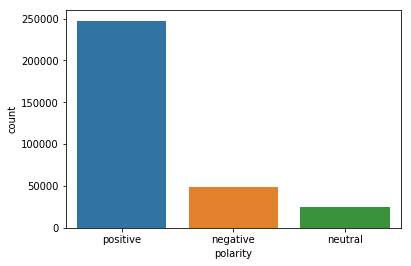

In [49]:
## plot the new grouped target by sentiment scores
seaborn.countplot(x=unique_doc['polarity'])

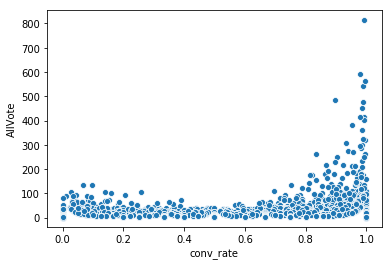

In [48]:
## visualizing the proportions of helpful vote conversion
seaborn.scatterplot(x='conv_rate', y='AllVote', data=unique_doc[unique_doc['conv_rate']>=0])

For an imbalanced class problem, the classifiers trained would be likely to be biased to the majority class when predicting on the test data, given a large and sparse feature set. Down-sampling the majority class sometimes outweighs the over-sampling of minority classes, as adopted by pioneer parties in the media technology domain, with the concerning benefits to avoid growing the training size and training time if the undersampled sample size still sufficed to deliver robust performance. Repeating the minority class samples might also overstate the weightings of some training features and cause overfitting. 

Ensemble-based algorithms in classification are powerful offering non-linear splittings adapted to mixed-type features. We might sample several under-sampled training sets, and compares or aggregates the predicted probabilities of outputs to search a threshold of cutting classes. For the TF-IDF matrix with over 22,000 sparse features, the truncated SVD helps reducing the complexity of high dimensions by a factor of 10, I kept 2000 components as result (~ 69.73% of total explained variance), and concatenated with the text length, topic grouping labels, and the 300 components retrieved from the Doc2Vec model as inputs.

In [34]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier, LGBMRegressor

In [35]:
## apply truncaetd SVD to the tf-idf matrix scaling down over 20,000 features to 2000 dimensions
from sklearn.decomposition import TruncatedSVD
trunc_tfidf = TruncatedSVD(n_components=2000, n_iter=25, random_state=42).fit(tfidf_matrix)

In [40]:
trunc_tfidf_matrix = trunc_tfidf.transform(tfidf_matrix)

In [41]:
trunc_tfidf_matrix.shape

(321847, 2000)

In [42]:
## investigate total proportion of variance explained
print(trunc_tfidf.explained_variance_ratio_.sum())

0.6973084030944123


In [49]:
sentiment_coo = sparse.hstack((unique_doc.iloc[:,10:11].to_sparse(), 
                               unique_doc.iloc[:,26:29].to_sparse(),
                               unique_doc.iloc[:,11:26].to_sparse(), 
                               trunc_tfidf_matrix, doc_vector.to_sparse()))

In [78]:
sentiment_coo.shape

(321847, 2319)

Random Forest and Gradient Boosting have given outstanding performance in data science competitions to solve real-world problems. XGBoost, CatBoost and AdaBoost are other potential choices. Starting with the 3-class target, 5 sets of under-sampled data were fitted to the two models, though the results turned out to be nearly equivalent with deviations of 0.01 or 0.02 in precision and recall scores of each class. Therefore, the best models were shown respectively. I did not tune the parameters in an intricate manner, yet just to point out some factors to consider. We might mitigate over-fitting specifying appropriate maximum depth of trees, and introducing the regularization terms of L1 and L2 penalities. Number of estimators would be suggested to set sufficiently large, as random forest aggregates the probabilities among bootstrapped trees in which more trees inferring more robust estimates, and the impressiveness of gradient boosting lied on integrating weak learners into strong learners by improving with the residuals in the preceding trees during the training process. Number of leaf nodes and the minimum size of the nodes would affect the extents of purities of classification.

In [50]:
## Sentiment Classification
## training and testing set split
sent_train_X, sent_test_X, sent_train_y, sent_test_y = train_test_split(
    sentiment_coo.tocsc()[:, 4:], unique_doc.iloc[:, 9],
    stratify = unique_doc.iloc[:, 9],
    test_size=0.2, shuffle=True, random_state=42)

In [51]:
## define a function for evaluating model performance
def model_performance(true, pred):
    print("Accuracy:" + str(accuracy_score(true, pred)))
    print(classification_report(true, pred))

In [129]:
## employ undersampling the positive sentiment class due to imbalanced data
from imblearn.under_sampling import RandomUnderSampler
class get_sentiment_food_review:
    def __init__(self, train_X, train_y, test_X, test_y, random_num):
        self.train_X = train_X
        self.train_y = train_y
        self.test_X = test_X
        self.test_y = test_y
        self.random_num = random_num
    def fit_procedure(self):
        self.X_res, self.y_res = self.undersample()
        return self.fit_one_batch(self.X_res, self.y_res)
    def undersample(self):
        rus = RandomUnderSampler(sampling_strategy='not minority', random_state=self.random_num)
        X_res, y_res = rus.fit_resample(self.train_X, self.train_y)
        return X_res, y_res
    def fit_one_batch(self, X_res, y_res):
        mrf = RandomForestClassifier(n_estimators=320, criterion='gini', max_depth=300, bootstrap=True, 
                                     class_weight='balanced', random_state=self.random_num).fit(X_res, y_res)
        mgb = LGBMClassifier(boosting_type='gbdt', objective='cross_entropy', num_iterations=1000, 
                             n_estimators=320, learning_rate=0.01, num_leaves=100, max_depth=-1,
                             n_jobs=4, min_data_in_leaf=10, random_state=self.random_num, 
                             lambda_l1=0.1, lambda_l2=0.01).fit(X_res, y_res)
        mrf_pred = mrf.predict(self.test_X)
        mgb_pred = mgb.predict(self.test_X)
        return mrf, mrf_pred, mgb, mgb_pred

In [60]:
random_list = [0, 42, 111, 999, 1234]

In [82]:
## for under-sampling, try 5 sets of sampled data for examinations
mrf1, mrf_pred1, mgb1, mgb_pred1 = get_sentiment_food_review(sent_train_X, sent_train_y, sent_test_X, sent_test_y, random_list[0]).fit_procedure()
mrf2, mrf_pred2, mgb2, mgb_pred2 = get_sentiment_food_review(sent_train_X, sent_train_y, sent_test_X, sent_test_y, random_list[1]).fit_procedure()
mrf3, mrf_pred3, mgb3, mgb_pred3 = get_sentiment_food_review(sent_train_X, sent_train_y, sent_test_X, sent_test_y, random_list[2]).fit_procedure()
mrf4, mrf_pred4, mgb4, mgb_pred4 = get_sentiment_food_review(sent_train_X, sent_train_y, sent_test_X, sent_test_y, random_list[3]).fit_procedure()
mrf5, mrf_pred5, mgb5, mgb_pred5 = get_sentiment_food_review(sent_train_X, sent_train_y, sent_test_X, sent_test_y, random_list[4]).fit_procedure()

Gradient Boosting suppassed Random Forest, but both were not satisfactory in the recall rates of all classes. The models were a bit too conservative o=in identifying positive-rated review contents, as indicated by a large number of false negatives of the positive class, and suffering confoundedness in distinguishing negative and neutral sentiments. As said, the 5 batches of under-samples only made 0.01 to 0.02 differences in precisions and recalls, combining models like voting classifiers would not make much enhancement.

Twisting to another approach, I reconstructed the settings to use only positive-vs-nonpositive and negative-vs-nonnegative to be the target attributes, and fit the 5 batches of under-samples to a deep neural network. The weighted F1 score (a harmonic mean measurement applicable to imbalanced data) showed marked improvements from 76% to 88% for positive sentiment and to 91% for negative sentiment. The precision for negative sentiment might still need to be improved as seeing around 1/3 of false positives in the confusion matrix, it would be neat to cross-validate to tune the parameters or trying out different algorithms.

In [85]:
## results of the 5 RF models were quite consistent, just showed the model with the best performance
model_performance(sent_test_y, mrf_pred2)

Accuracy:0.6637564082647196
              precision    recall  f1-score   support

    negative       0.47      0.65      0.54      9858
     neutral       0.18      0.52      0.26      5012
    positive       0.94      0.68      0.79     49500

   micro avg       0.66      0.66      0.66     64370
   macro avg       0.53      0.62      0.53     64370
weighted avg       0.81      0.66      0.71     64370



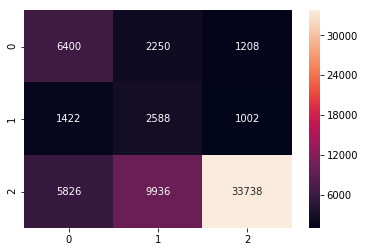

In [120]:
## Confusion matrix of the Random Forest classifier results
seaborn.heatmap(confusion_matrix(sent_test_y, mrf_pred2), annot=True, fmt="d")

In [105]:
## results of the 5 GBT models were quite consistent, just showed the model with the best performance
model_performance(sent_test_y, mgb_pred3)

Accuracy:0.7223862047537672
              precision    recall  f1-score   support

    negative       0.56      0.70      0.62      9858
     neutral       0.22      0.60      0.32      5012
    positive       0.96      0.74      0.83     49500

   micro avg       0.72      0.72      0.72     64370
   macro avg       0.58      0.68      0.59     64370
weighted avg       0.84      0.72      0.76     64370



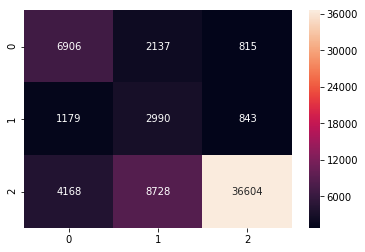

In [117]:
## Confusion matrix of the gradient boosting classifier results
seaborn.heatmap(confusion_matrix(sent_test_y, mgb_pred3), annot=True, fmt="d")

In [122]:
## Trying a stepwise approach to boost the accuracy on positive classes and negative classes
## positive targets
sent_train_X_pos, sent_test_X_pos, sent_train_y_pos, sent_test_y_pos = train_test_split(
    sentiment_coo.tocsc()[:, 4:], sentiment_coo.tocsc()[:, 3].toarray(),
    stratify = sentiment_coo.tocsc()[:, 3].toarray(),
    test_size=0.2, shuffle=True, random_state=42)
## negative targets
sent_train_X_neg, sent_test_X_neg, sent_train_y_neg, sent_test_y_neg = train_test_split(
    sentiment_coo.tocsc()[:, 4:], sentiment_coo.tocsc()[:, 1].toarray(),
    stratify = sentiment_coo.tocsc()[:, 1].toarray(),
    test_size=0.2, shuffle=True, random_state=42)

In [176]:
from keras.layers import Input, Dense, Activation, Dropout, BatchNormalization
from keras.optimizers import Adam
from keras import Sequential

class get_sentiment_food_review_net:
    def __init__(self, train_X, train_y, test_X, test_y, random_num):
        self.train_X = train_X.toarray()
        self.train_y = train_y
        self.test_X = test_X.toarray()
        self.test_y = test_y
        self.random_num = random_num
        
    def undersample(self, random_seed):
        rus = RandomUnderSampler(sampling_strategy='not minority', random_state=random_seed)
        X_res, y_res = rus.fit_resample(self.train_X, self.train_y)
        return X_res, y_res
    
    def fit(self):
        classifier_struct = Sequential([
            BatchNormalization(input_shape=(self.train_X.shape[1], )),
            Dense(2500, activation='relu'),
            Dense(500, activation='relu'),
            Dropout(0.2),
            Dense(500, activation='relu'),
            Dropout(0.2),
            Dense(200, activation='relu'),
            Dropout(0.2),
            Dense(200, activation='relu'),
            Dropout(0.2),
            Dense(20, activation='relu'),
            Dense(1),
            Activation('sigmoid')
        ])
        classifier_struct.compile(optimizer=Adam(lr=0.00001), loss='binary_crossentropy', metrics=['accuracy'])
        for i in range(len(self.random_num)):
            X_res, y_res = self.undersample(self.random_num[i])
            classifier = classifier_struct.fit(X_res, y_res, epochs=5, batch_size=50, validation_split=0.1)
           
        predict = classifier_struct.predict_classes(self.test_X)
        predict_proba = classifier_struct.predict_proba(self.test_X)
        return classifier_struct, predict, predict_proba

In [158]:
pos_classifier_struct, pos_predict, pos_predict_proba = get_sentiment_food_review_net(
                                                            sent_train_X_pos, sent_train_y_pos, 
                                                            sent_test_X_pos, sent_test_y_pos, random_list).fit()

Train on 107065 samples, validate on 11897 samples
Epoch 1/5
107065/107065 [==============================] - 339s 3ms/step - loss: 0.5258 - acc: 0.7260 - val_loss: 0.4568 - val_acc: 0.8127
Epoch 2/5
107065/107065 [==============================] - 333s 3ms/step - loss: 0.3607 - acc: 0.8483 - val_loss: 0.3587 - val_acc: 0.8502
Epoch 3/5
107065/107065 [==============================] - 334s 3ms/step - loss: 0.3169 - acc: 0.8673 - val_loss: 0.3377 - val_acc: 0.8564
Epoch 4/5
107065/107065 [==============================] - 333s 3ms/step - loss: 0.2860 - acc: 0.8834 - val_loss: 0.3563 - val_acc: 0.8469
Epoch 5/5
107065/107065 [==============================] - 325s 3ms/step - loss: 0.2570 - acc: 0.8968 - val_loss: 0.3413 - val_acc: 0.8550
Train on 107065 samples, validate on 11897 samples
Epoch 1/5
107065/107065 [==============================] - 322s 3ms/step - loss: 0.2727 - acc: 0.8903 - val_loss: 0.2761 - val_acc: 0.8795
Epoch 2/5
107065/107065 [==============================] - 319s 

In [168]:
model_performance(sent_test_y_pos, pos_predict)

Accuracy:0.8790430324685412
              precision    recall  f1-score   support

         0.0       0.71      0.79      0.75     14870
         1.0       0.94      0.91      0.92     49500

   micro avg       0.88      0.88      0.88     64370
   macro avg       0.83      0.85      0.84     64370
weighted avg       0.88      0.88      0.88     64370



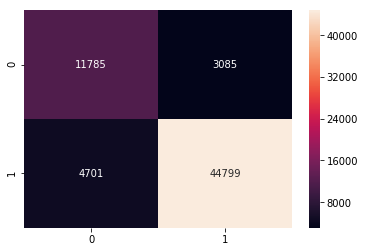

In [167]:
seaborn.heatmap(confusion_matrix(sent_test_y_pos, pos_predict), annot=True, fmt="d")

In [173]:
neg_classifier_struct, neg_predict, neg_predict_proba = get_sentiment_food_review_net(
                                                            sent_train_X_neg, sent_train_y_neg, 
                                                            sent_test_X_neg, sent_test_y_neg, random_list).fit()

Train on 70977 samples, validate on 7887 samples
Epoch 1/5
70977/70977 [==============================] - 228s 3ms/step - loss: 0.5930 - acc: 0.6654 - val_loss: 0.4748 - val_acc: 0.7578
Epoch 2/5
70977/70977 [==============================] - 221s 3ms/step - loss: 0.3662 - acc: 0.8472 - val_loss: 0.4085 - val_acc: 0.8221
Epoch 3/5
70977/70977 [==============================] - 226s 3ms/step - loss: 0.3114 - acc: 0.8734 - val_loss: 0.3824 - val_acc: 0.8434
Epoch 4/5
70977/70977 [==============================] - 225s 3ms/step - loss: 0.2797 - acc: 0.8866 - val_loss: 0.3780 - val_acc: 0.8459
Epoch 5/5
70977/70977 [==============================] - 221s 3ms/step - loss: 0.2525 - acc: 0.8997 - val_loss: 0.3616 - val_acc: 0.8569
Train on 70977 samples, validate on 7887 samples
Epoch 1/5
70977/70977 [==============================] - 219s 3ms/step - loss: 0.2645 - acc: 0.8938 - val_loss: 0.3709 - val_acc: 0.8623
Epoch 2/5
70977/70977 [==============================] - 219s 3ms/step - loss: 0

In [178]:
model_performance(sent_test_y_neg, neg_predict)

Accuracy:0.90281186888302
              precision    recall  f1-score   support

         0.0       0.96      0.93      0.94     54512
         1.0       0.66      0.76      0.71      9858

   micro avg       0.90      0.90      0.90     64370
   macro avg       0.81      0.84      0.82     64370
weighted avg       0.91      0.90      0.91     64370



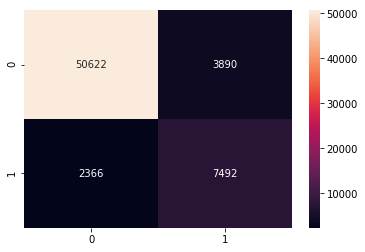

In [179]:
seaborn.heatmap(confusion_matrix(sent_test_y_neg, neg_predict), annot=True, fmt="d")